# An√°lisis de Cl√∫stering


In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import scale
from sklearn.cluster import KMeans
import scipy.cluster.hierarchy as sch
import matplotlib.pyplot as plt
import seaborn as sns
from pyclustertend import hopkins, vat
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import sys
import matplotlib.cm as cm
from sklearn.decomposition import PCA
import scipy.cluster.hierarchy as sch


### An√°lisis de Agrupamiento de datos realizados


<small>

**Perfil b√°sico de la v√≠ctima**
1. VICTIMA_EDAD
2. VICTIMA_ESCOLARIDAD

**Perfil ocupacional de la v√≠ctima**
1. VICTIMA_OCUP
2. VICTIMA_DEDICA
3. VICTIMA_TRABAJA

**Perfil b√°sico del agresor**
1. AGRESOR_EDAD
2. AGRESOR_ESCOLARIDAD

**Perfil ocupacional del agresor**
1. AGRESOR_OCUP
2. AGRESOR_DEDICA
3. AGRESOR_TRABAJA

**Relaci√≥n y tipo de agresi√≥n**
1. VICTIMA_RELACION_AGRESOR
2. HEC_TIPAGRE
3. VICTIMA_EDAD

**Contexto geogr√°fico del hecho**
1. DEPTO_MCPIO
2. HEC_DEPTOMCPIO
3. VICTIMA_TRABAJA

</small>


### Cargar DataFrame


In [2]:
df = pd.read_csv("../CSV/UnidoPorA√±oCSV/vif_all_years.csv")

/var/folders/kd/4y1c0b3j1273_pm_gb0hfhdw0000gn/T/ipykernel_3657/555449755.py:1: DtypeWarning: Columns (0,3,7,8,9,10,11,12,15,16,17,19,28,29,31,33,38,42,43,45,48,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("../CSV/UnidoPorA√±oCSV/vif_all_years.csv")


An√°lisis de Matriz de Correlaci√≥n

In [3]:
columnas_para_clustering = [
    'VIC_EDAD', 'VIC_ESCOLARIDAD',
    'VIC_OCUP', 'VIC_DEDICA', 'VIC_TRABAJA',
    'AGR_EDAD', 'AGR_ESCOLARIDAD',
    'AGR_OCUP', 'AGR_DEDICA', 'AGR_TRABAJA',
    'VIC_REL_AGR', 'HEC_TIPAGRE',
    'DEPTO_MCPIO', 'HEC_DEPTOMCPIO'
]


/var/folders/kd/4y1c0b3j1273_pm_gb0hfhdw0000gn/T/ipykernel_3657/23183120.py:14: UserWarning: Glyph 128279 (\N{LINK SYMBOL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Users/gerco/UVG/7th_Semester/Data_Mining/PR3/venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128279 (\N{LINK SYMBOL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


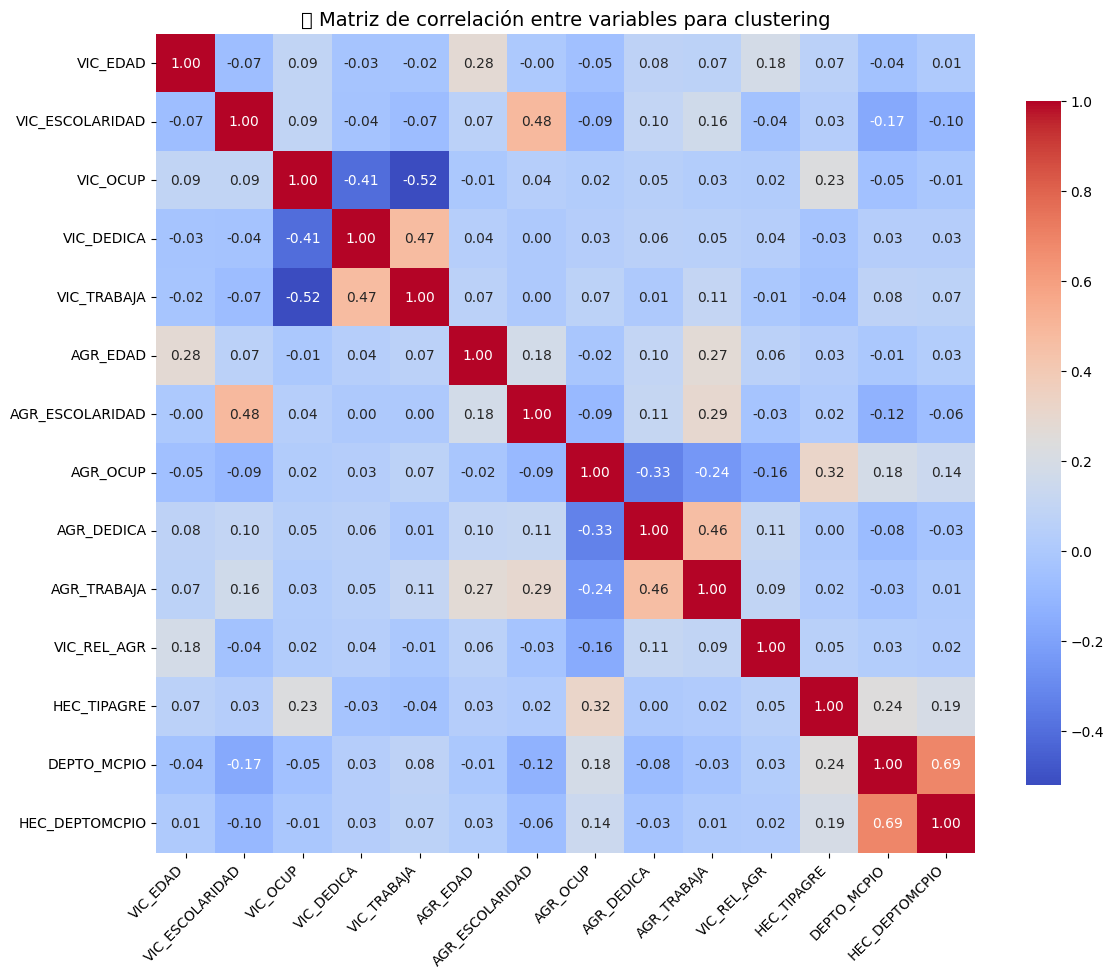

In [4]:
# Crear el mapa de calor de correlaciones
plt.figure(figsize=(12, 10))
df_corr = df[columnas_para_clustering].apply(pd.to_numeric, errors='coerce').fillna(0)
sns.heatmap(
    df_corr.corr(),
    annot=True,
    cmap='coolwarm',
    fmt='.2f',
    square=True,
    cbar_kws={"shrink": .8}
)
plt.title("üîó Matriz de correlaci√≥n entre variables para clustering", fontsize=14)
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


### An√°lisis de la Matriz de Correlaci√≥n

La matriz de correlaci√≥n muestra, en general, **baja correlaci√≥n** entre la mayor√≠a de las variables. Esto es positivo para el an√°lisis de clustering, ya que indica que cada variable aporta informaci√≥n distinta y relevante. A continuaci√≥n, se destacan las correlaciones m√°s notables:

- **VIC_OCUP** y **VIC_TRABAJA** (-0.52):  
  Sugiere que ciertos c√≥digos de ocupaci√≥n est√°n fuertemente relacionados con no trabajar.

- **VIC_DEDICA** y **VIC_TRABAJA** (0.47):  
  Es l√≥gico, ya que a mayor dedicaci√≥n ocupacional, mayor probabilidad de estar trabajando.

- **AGR_TRABAJA** y **AGR_DEDICA** (0.46), y **AGR_OCUP** con **AGR_DEDICA** (-0.33):  
  Estas correlaciones son coherentes con los patrones laborales del agresor.

- **DEPTO_MCPIO** y **HEC_DEPTOMCPIO** (0.69):  
  Existe una alta correlaci√≥n esperada, ya que ambas variables se refieren al lugar del hecho, posiblemente con codificaci√≥n similar.

#### Observaciones adicionales:
- Las correlaciones entre las variables de la v√≠ctima y el agresor son **bajas o nulas**, lo cual respalda que sus perfiles puedan ser clusterizados por separado.
- La relaci√≥n con el agresor (**VIC_REL_AGR**) no muestra una relaci√≥n fuerte con ninguna otra variable, lo que indica que puede funcionar como una dimensi√≥n independiente de an√°lisis.

Estas caracter√≠sticas refuerzan la utilidad de las variables seleccionadas para el an√°lisis de clustering.



In [5]:
print(df_corr.corr())

                 VIC_EDAD  VIC_ESCOLARIDAD  VIC_OCUP  VIC_DEDICA  VIC_TRABAJA  \
VIC_EDAD         1.000000        -0.068554  0.092458   -0.031249    -0.024935   
VIC_ESCOLARIDAD -0.068554         1.000000  0.091352   -0.038570    -0.069843   
VIC_OCUP         0.092458         0.091352  1.000000   -0.405082    -0.520610   
VIC_DEDICA      -0.031249        -0.038570 -0.405082    1.000000     0.472630   
VIC_TRABAJA     -0.024935        -0.069843 -0.520610    0.472630     1.000000   
AGR_EDAD         0.279821         0.065050 -0.005835    0.043080     0.067339   
AGR_ESCOLARIDAD -0.000432         0.484293  0.040847    0.004838     0.002381   
AGR_OCUP        -0.054343        -0.092996  0.022430    0.032841     0.069066   
AGR_DEDICA       0.077451         0.101193  0.047560    0.058500     0.006777   
AGR_TRABAJA      0.071562         0.163471  0.026638    0.051890     0.107421   
VIC_REL_AGR      0.183864        -0.044391  0.020837    0.042535    -0.006531   
HEC_TIPAGRE      0.065463   

### Limpieza de Datos


In [6]:
# üîΩ 1. Solo las columnas necesarias desde el inicio
columnas_para_clustering = [
    'VIC_EDAD', 'VIC_ESCOLARIDAD',
    'VIC_OCUP', 'VIC_DEDICA', 'VIC_TRABAJA',
    'AGR_EDAD', 'AGR_ESCOLARIDAD',
    'AGR_OCUP', 'AGR_DEDICA', 'AGR_TRABAJA',
    'VIC_REL_AGR', 'HEC_TIPAGRE',
    'DEPTO_MCPIO', 'HEC_DEPTOMCPIO'
]

df_temp = df[columnas_para_clustering].copy()

# üîΩ 2. Reemplazar solo en estas columnas (no en todo el DataFrame)
df_temp.replace('', pd.NA, inplace=True)
df_temp = df_temp.apply(pd.to_numeric, errors='coerce')
df_temp.fillna(0, inplace=True)

# üîΩ 3. Escalar
scaler = StandardScaler()
df_clustering = scaler.fit_transform(df_temp)
df_ready = pd.DataFrame(df_clustering, columns=columnas_para_clustering)

# üîΩ 4. Crear estrato sobre columnas discretas (¬°no todas!)
columnas_para_estrato = [
    'VIC_ESCOLARIDAD', 'VIC_OCUP', 'VIC_TRABAJA',
    'AGR_ESCOLARIDAD', 'AGR_OCUP', 'AGR_TRABAJA',
    'VIC_REL_AGR', 'HEC_TIPAGRE',
    'DEPTO_MCPIO', 'HEC_DEPTOMCPIO'
]
df_estrato = df_temp[columnas_para_estrato].astype(str)
df_temp["estrato"] = df_estrato.agg("_".join, axis=1)

# üîΩ 5. Muestreo estratificado (con m√≠nimo 1 por grupo)
df_sample = df_temp.groupby("estrato", group_keys=False).apply(
    lambda x: x.sample(n=min(max(1, int(len(x) * 0.05)), len(x)), random_state=42)
)

# üîΩ 6. Subset del DataFrame escalado
df_ready_sample = df_ready.loc[df_sample.index]

# ‚úÖ Vista previa
print(f"‚úÖ Muestra creada: {df_ready_sample.shape}")
print(df_ready_sample.head())

‚úÖ Muestra creada: (384501, 14)
        VIC_EDAD  VIC_ESCOLARIDAD  VIC_OCUP  VIC_DEDICA  VIC_TRABAJA  \
340748 -1.950826        -1.777907 -0.589728   -0.754329    -2.362682   
335285 -1.883985        -1.777907 -0.589728   -0.754329    -2.362682   
368554 -1.883985        -1.777907 -0.589728   -0.754329    -2.362682   
373493 -2.151350        -1.777907 -0.589728   -0.754329    -2.362682   
247740 -1.950826        -1.777907 -0.589728   -0.754329    -2.362682   

        AGR_EDAD  AGR_ESCOLARIDAD  AGR_OCUP  AGR_DEDICA  AGR_TRABAJA  \
340748 -0.503922        -1.193678 -1.340524   -0.355105    -0.319226   
335285  3.131966        -1.193678 -1.340524   -0.355105    -0.319226   
368554 -1.646629        -1.193678 -1.340524    3.866329     0.327849   
373493  0.327138        -1.193678 -1.340524    0.113943     0.327849   
247740 -0.451981        -1.193678 -1.340524    3.866329     0.327849   

        VIC_REL_AGR  HEC_TIPAGRE  DEPTO_MCPIO  HEC_DEPTOMCPIO  
340748     0.245840    -2.007726    -

/var/folders/kd/4y1c0b3j1273_pm_gb0hfhdw0000gn/T/ipykernel_3657/723451560.py:34: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_sample = df_temp.groupby("estrato", group_keys=False).apply(


### Agrupamiento por clusters predichos


In [7]:
# Clustering del perfil b√°sico de la v√≠ctima
grupo_perfil_victima = [
    "VIC_EDAD",
    "VIC_ESCOLARIDAD"
]

# Clustering del perfil ocupacional de la v√≠ctima
grupo_ocupacion_victima = [
    "VIC_OCUP",
    "VIC_DEDICA",
]

# Clustering del perfil b√°sico del agresor
grupo_perfil_agresor = [
    "AGR_EDAD",
    "AGR_ESCOLARIDAD"
]

# Clustering del perfil ocupacional del agresor
grupo_ocupacion_agresor = [
    "AGR_OCUP",
    "AGR_DEDICA",
]

# Clustering de la relaci√≥n y tipo de agresi√≥n
grupo_relacion_agresion = [
    "VIC_REL_AGR",
    "HEC_TIPAGRE",
    "VIC_EDAD"
]

# Clustering del contexto geogr√°fico del hecho
grupo_contexto_geografico = [
    "DEPTO_MCPIO",
    "HEC_DEPTOMCPIO",
]

### Creaci√≥n de DataFrames por Grupo


In [8]:
df_perfil_victima = df_ready[grupo_perfil_victima].dropna().copy()
df_ocupacion_victima = df_ready[grupo_ocupacion_victima].dropna().copy()
df_perfil_agresor = df_ready[grupo_perfil_agresor].dropna().copy()
df_ocupacion_agresor = df_ready[grupo_ocupacion_agresor].dropna().copy()
df_relacion_agresion = df_ready[grupo_relacion_agresion].dropna().copy()
df_contexto_geografico = df_ready[grupo_contexto_geografico].dropna().copy()

### An√°lisis de Hopkins


In [9]:
# Escalar los grupos 
df_perfil_victima_scaled = scale(df_perfil_victima)
df_ocupacion_victima_scaled = scale(df_ocupacion_victima)
df_perfil_agresor_scaled = scale(df_perfil_agresor)
df_ocupacion_agresor_scaled = scale(df_ocupacion_agresor)
df_relacion_agresion_scaled = scale(df_relacion_agresion)
df_contexto_geografico_scaled = scale(df_contexto_geografico)

In [10]:
# Calcular y mostrar estad√≠stico de Hopkins por grupo
n_muestra = lambda x: min(15000, int(0.05 * len(x)))

print(f"Perfil v√≠ctima:         {hopkins(df_perfil_victima_scaled, n_muestra(df_perfil_victima_scaled))}")
print(f"Ocupaci√≥n v√≠ctima:      {hopkins(df_ocupacion_victima_scaled, n_muestra(df_ocupacion_victima_scaled))}")
print(f"Perfil agresor:         {hopkins(df_perfil_agresor_scaled, n_muestra(df_perfil_agresor_scaled))}")
print(f"Ocupaci√≥n agresor:      {hopkins(df_ocupacion_agresor_scaled, n_muestra(df_ocupacion_agresor_scaled))}")
print(f"Relaci√≥n/agresi√≥n:      {hopkins(df_relacion_agresion_scaled, n_muestra(df_relacion_agresion_scaled))}")
print(f"Contexto geogr√°fico:    {hopkins(df_contexto_geografico_scaled, n_muestra(df_contexto_geografico_scaled))}")


Perfil v√≠ctima:         7.719561972684879e-05
Ocupaci√≥n v√≠ctima:      1.5770372896178766e-08
Perfil agresor:         7.361345362292053e-05
Ocupaci√≥n agresor:      1.975016167165444e-08
Relaci√≥n/agresi√≥n:      0.00023653662913937333
Contexto geogr√°fico:    1.870646672200813e-05


### N√∫mero de clusters adecuados con gr√°ficas de codo


In [11]:
def elbow_plot_for_group(features, group_name):
    # Extraer subconjunto
    df_group = df_ready[features].copy()

    # Convertir a num√©rico y llenar NaNs con la mediana
    for col in features:
        df_group[col] = pd.to_numeric(df_group[col], errors='coerce')
    df_group.fillna(df_group.median(numeric_only=True), inplace=True)

    # Normalizar
    X_scaled = scale(df_group)

    # Elbow method
    wcss = []
    for i in range(1, 11):
        kmeans = KMeans(n_clusters=i, random_state=42, n_init='auto')
        kmeans.fit(X_scaled)
        wcss.append(kmeans.inertia_)

    # Gr√°fico
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, 11), wcss, marker='o')
    plt.title(f"Gr√°fico del Codo - {group_name}")
    plt.xlabel("N√∫mero de Clusters (k)")
    plt.ylabel("Suma de cuadrados intra-cluster (WCSS)")
    plt.xticks(range(1, 11))
    plt.grid(True)
    plt.show()

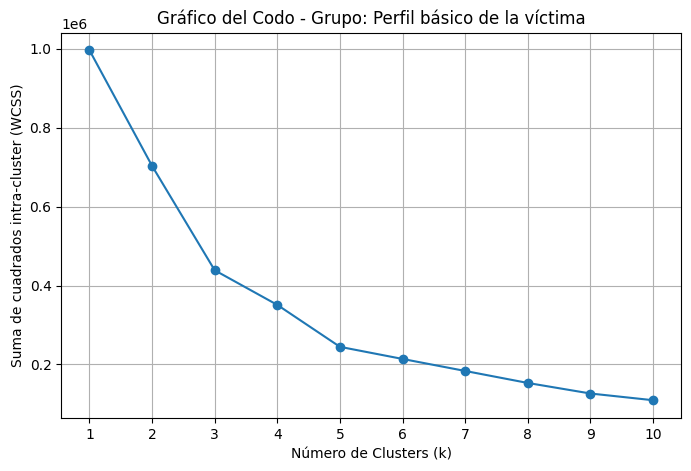

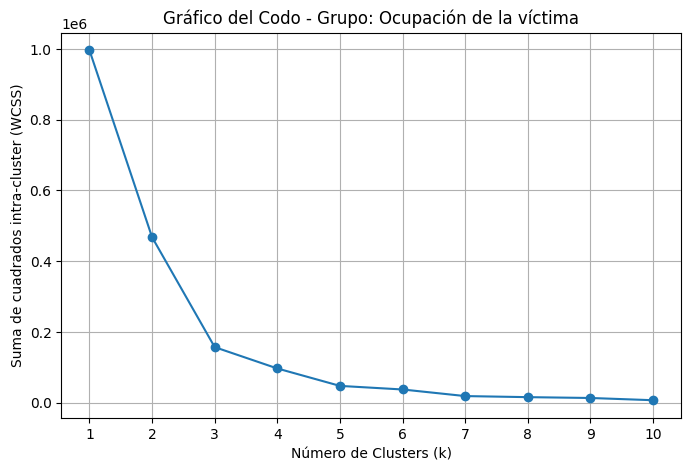

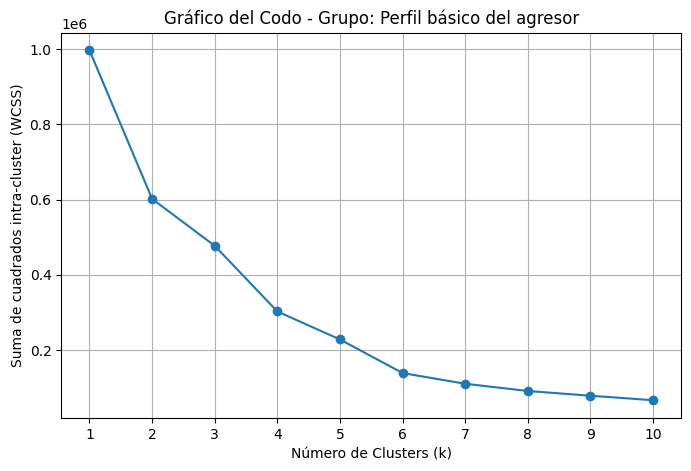

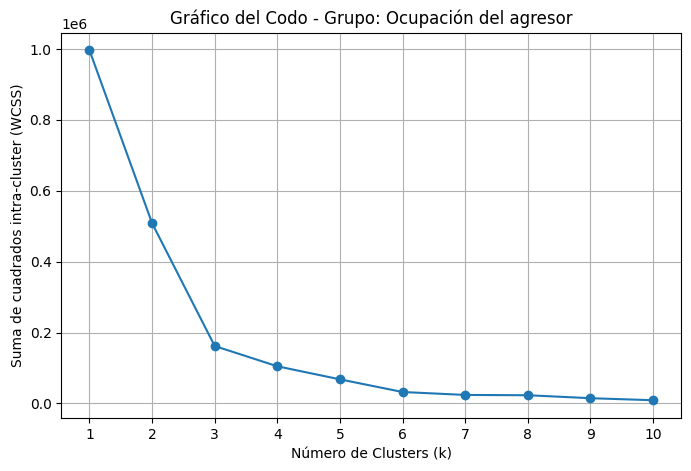

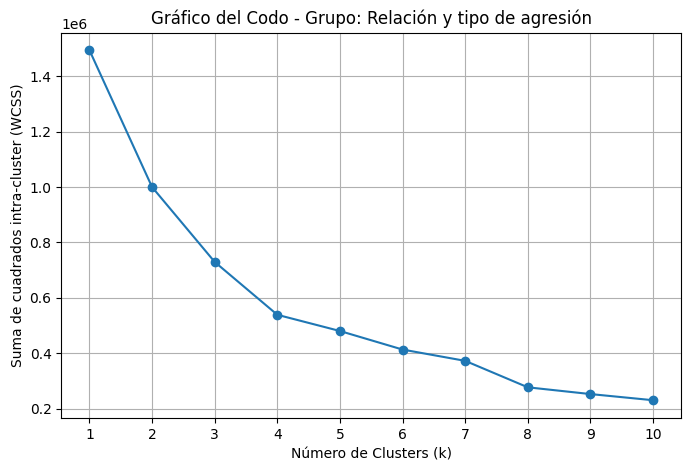

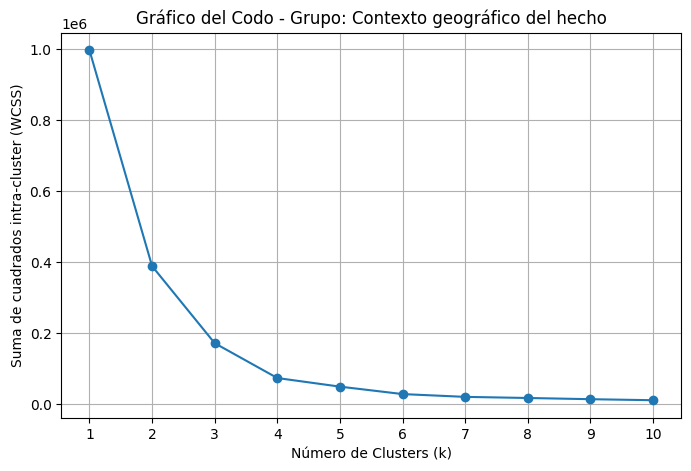

In [12]:
elbow_plot_for_group(grupo_perfil_victima, "Grupo: Perfil b√°sico de la v√≠ctima")
elbow_plot_for_group(grupo_ocupacion_victima, "Grupo: Ocupaci√≥n de la v√≠ctima")
elbow_plot_for_group(grupo_perfil_agresor, "Grupo: Perfil b√°sico del agresor")
elbow_plot_for_group(grupo_ocupacion_agresor, "Grupo: Ocupaci√≥n del agresor")
elbow_plot_for_group(grupo_relacion_agresion, "Grupo: Relaci√≥n y tipo de agresi√≥n")
elbow_plot_for_group(grupo_contexto_geografico, "Grupo: Contexto geogr√°fico del hecho")

En los seis gr√°ficos, observamos una clara disminuci√≥n de la suma de cuadrados intra-cluster (WCSS) al aumentar el n√∫mero de clusters, pero el punto de inflexi√≥n ‚Äîo "codo"‚Äî se identifica consistentemente en k = 3, especialmente en los grupos de ocupaci√≥n de la v√≠ctima, ocupaci√≥n del agresor y contexto geogr√°fico del hecho, donde la curva se estabiliza notoriamente despu√©s de ese valor. Esto indica que tres clusters explican de forma eficiente la variabilidad en los datos, sin a√±adir complejidad innecesaria. En los grupos como perfil b√°sico del agresor o relaci√≥n y tipo de agresi√≥n, el descenso es m√°s progresivo, pero aun as√≠ k = 3 sigue siendo un valor razonable, alineado con el an√°lisis de silueta anterior. Este resultado refuerza que, para los fines de clasificaci√≥n o segmentaci√≥n, la elecci√≥n de tres perfiles distintos por grupo es tanto v√°lida como √∫til para describir los diferentes contextos y caracter√≠sticas sociodemogr√°ficas en los casos de violencia intrafamiliar.

## Clusters recomendados para cada grupo

<small>

### Clustering del perfil b√°sico de la v√≠ctima (3 seg√∫n an√°lisis)
Variables:
1. VIC_EDAD
2. VIC_ESCOLARIDAD

### Clustering del perfil ocupacional de la v√≠ctima (3 seg√∫n an√°lisis)
Variables:
1. VIC_OCUP
2. VIC_DEDICA

### Clustering del perfil b√°sico del agresor (2 seg√∫n an√°lisis)
Variables:
1. AGR_EDAD
2. AGR_ESCOLARIDAD

### Clustering del perfil ocupacional del agresor (3 seg√∫n an√°lisis)
Variables:
1. AGR_OCUP
2. AGR_DEDICA

### Clustering de la relaci√≥n y tipo de agresi√≥n (2 seg√∫n an√°lisis)
Variables:
1. VIC_REL_AGR
2. HEC_TIPAGRE
3. VIC_EDAD

### Clustering del contexto geogr√°fico del hecho (2 seg√∫n an√°lisis)
Variables:
1. DEPTO_MCPIO
2. HEC_DEPTOMCPIO

</small>


## C√°lculo de K-Medias

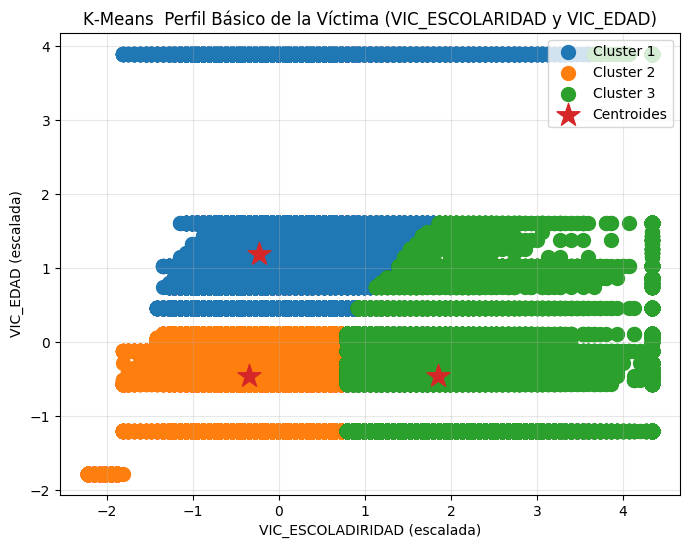

In [13]:
# -------------- GRUPO 1: Perfil B√°sico de la V√≠ctima --------------


# Seleccionar s√≥lo las dos columnas de inter√©s
X_perfil_victima = df_perfil_victima_scaled

# Ajustar K‚ÄëMeans
km_perfil_victima = KMeans(n_clusters=3, random_state=42).fit(X_perfil_victima)
labels_perfil_victima = km_perfil_victima.labels_
centroids_perfil_victima = km_perfil_victima.cluster_centers_

# Graficar resultados en 2D
plt.figure(figsize=(8,6))
for cluster in range(3):
    mask = (labels_perfil_victima == cluster)
    plt.scatter(X_perfil_victima[mask, 0],
                X_perfil_victima[mask, 1],
                s=100,
                label=f'Cluster {cluster+1}')

plt.scatter(centroids_perfil_victima[:, 0],
            centroids_perfil_victima[:, 1],
            marker='*',
            s=300,
            label='Centroides')

plt.title("K‚ÄëMeans  Perfil B√°sico de la V√≠ctima (VIC_ESCOLARIDAD y VIC_EDAD)")
plt.xlabel("VIC_ESCOLADIRIDAD (escalada)")
plt.ylabel("VIC_EDAD (escalada)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

El gr√°fico muestra una segmentaci√≥n clara en tres clusters bien diferenciados. Podemos observar lo siguiente:

- **Cluster 1 (azul):** Agrupa a v√≠ctimas con edad elevada y escolaridad media-baja, lo cual podr√≠a asociarse a personas adultas con estudios b√°sicos o medios.

- **Cluster 2 (naranja):** Se concentra en v√≠ctimas j√≥venes con baja escolaridad, lo que sugiere un perfil de alta vulnerabilidad educativa y posiblemente econ√≥mica.

- **Cluster 3 (verde):** Re√∫ne a v√≠ctimas con escolaridad alta pero edad m√°s baja a intermedia, indicando posiblemente un grupo con mayor acceso educativo y potencialmente mayor conocimiento de rutas de denuncia.

Los centroides resaltados con estrellas rojas indican los valores medios representativos de cada grupo, confirmando una diferenciaci√≥n tanto por nivel educativo como por etapa de vida. Este clustering es muy √∫til para dise√±ar estrategias diferenciadas de intervenci√≥n y prevenci√≥n, seg√∫n el perfil sociodemogr√°fico predominante.

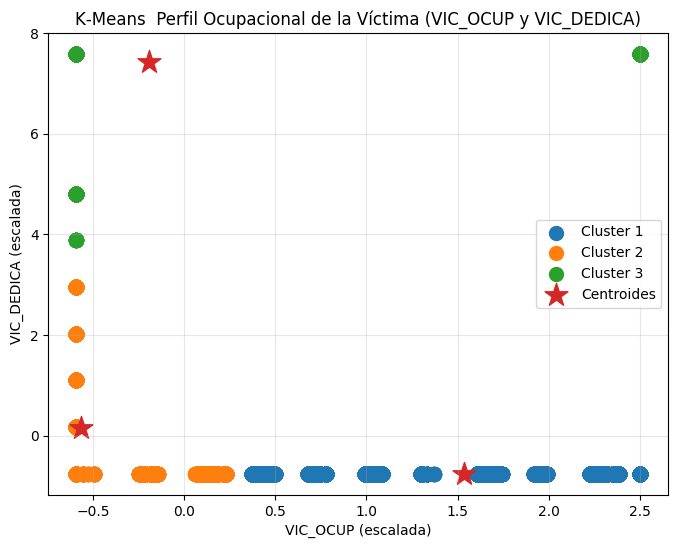

In [14]:
# -------------- GRUPO 2: Perfil Ocupacional de la V√≠ctima --------------


# Seleccionar s√≥lo las dos columnas de inter√©s
X_ocupacion_victima = df_ocupacion_victima_scaled

# Ajustar K‚ÄëMeans
km_ocupacion_victima = KMeans(n_clusters=3, random_state=42).fit(X_ocupacion_victima)
labels_ocupacion_victima = km_ocupacion_victima.labels_
centroids_ocupacion_victima = km_ocupacion_victima.cluster_centers_

# Graficar resultados en 2D
plt.figure(figsize=(8,6))
for cluster in range(3):
    mask = (labels_ocupacion_victima == cluster)
    plt.scatter(X_ocupacion_victima[mask, 0],
                X_ocupacion_victima[mask, 1],
                s=100,
                label=f'Cluster {cluster+1}')

plt.scatter(centroids_ocupacion_victima[:, 0],
            centroids_ocupacion_victima[:, 1],
            marker='*',
            s=300,
            label='Centroides')

plt.title("K‚ÄëMeans  Perfil Ocupacional de la V√≠ctima (VIC_OCUP y VIC_DEDICA)")
plt.xlabel("VIC_OCUP (escalada)")
plt.ylabel("VIC_DEDICA (escalada)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

El gr√°fico muestra tres clusters bien diferenciados en cuanto al tipo de ocupaci√≥n y dedicaci√≥n de las v√≠ctimas:

- **Cluster 1 (azul):** Agrupa principalmente a v√≠ctimas con ocupaciones m√°s estables y variadas, pero con valores bajos en dedicaci√≥n, lo que podr√≠a sugerir empleo parcial o informal.

- **Cluster 2 (naranja):** Se ubica en un rango inferior tanto en ocupaci√≥n como en dedicaci√≥n, representando probablemente a v√≠ctimas sin empleo definido o con escasa participaci√≥n en actividades productivas.

- **Cluster 3 (verde):** Aunque peque√±o y disperso, contiene a v√≠ctimas con alt√≠sima dedicaci√≥n (valores at√≠picos), posiblemente personas que se dedican completamente a una ocupaci√≥n informal, el hogar u otro tipo de actividad no estandarizada.

Los centroides (estrellas rojas) reflejan bien estas diferencias. Este patr√≥n sugiere que el perfil ocupacional de la v√≠ctima podr√≠a tener relaci√≥n con su nivel de exposici√≥n, acceso a redes de apoyo o decisiones sobre d√≥nde y c√≥mo denunciar.

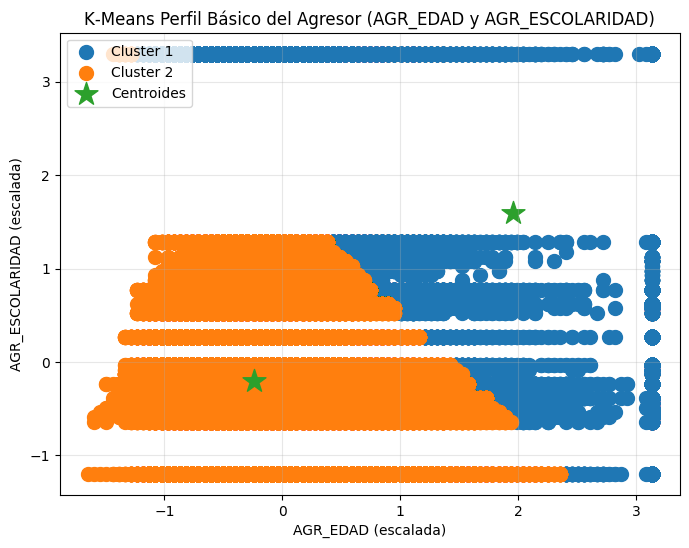

In [15]:
# -------------- GRUPO 3: Perfil B√°sico del Agresor --------------


# Seleccionar s√≥lo las dos columnas de inter√©s
X_perfil_agresor = df_perfil_agresor_scaled

# Ajustar K‚ÄëMeans
km_perfil_agresor = KMeans(n_clusters=2, random_state=42).fit(X_perfil_agresor)
labels_perfil_agresor = km_perfil_agresor.labels_
centroids_perfil_agresor = km_perfil_agresor.cluster_centers_

# Graficar resultados en 2D
plt.figure(figsize=(8,6))
for cluster in range(2):
    mask = (labels_perfil_agresor == cluster)
    plt.scatter(X_perfil_agresor[mask, 0],
                X_perfil_agresor[mask, 1],
                s=100,
                label=f'Cluster {cluster+1}')

plt.scatter(centroids_perfil_agresor[:, 0],
            centroids_perfil_agresor[:, 1],
            marker='*',
            s=300,
            label='Centroides')

plt.title("K‚ÄëMeans Perfil B√°sico del Agresor (AGR_EDAD y AGR_ESCOLARIDAD)")
plt.xlabel("AGR_EDAD (escalada)")
plt.ylabel("AGR_ESCOLARIDAD (escalada)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

### An√°lisis del Clustering: Perfil B√°sico del Agresor

El clustering revela dos grupos bien diferenciados:

- **Cluster 1 (azul):** Representa agresores con edad m√°s avanzada y mayor nivel educativo. Su concentraci√≥n en la zona superior derecha sugiere adultos con cierto acceso a formaci√≥n formal.

- **Cluster 2 (naranja):** Agrupa a agresores m√°s j√≥venes y con menor escolaridad, lo cual puede reflejar un perfil de mayor vulnerabilidad estructural y posiblemente m√°s impulsividad o menor acceso a recursos.

Los centroides (estrellas verdes) validan esta segmentaci√≥n y muestran c√≥mo el factor educativo puede marcar una diferencia clara en combinaci√≥n con la edad. Esto podr√≠a tener implicaciones tanto para el an√°lisis del riesgo como para estrategias de intervenci√≥n diferenciada.

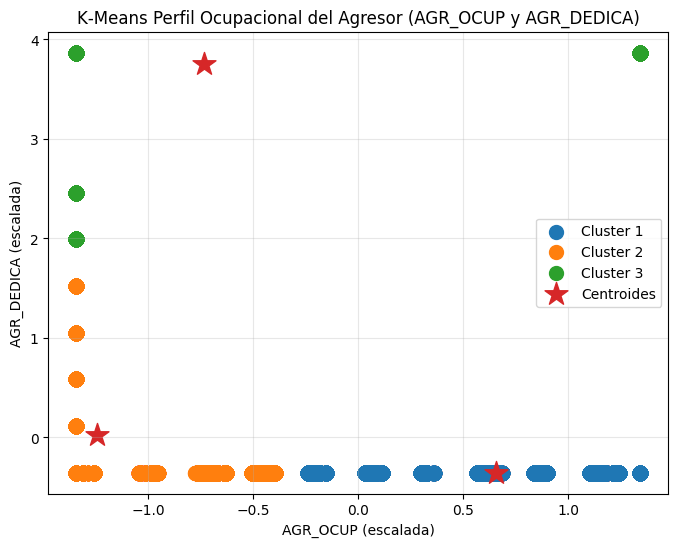

In [16]:
# -------------- GRUPO 5: Perfil Ocupacional del Agresor --------------

# Seleccionar s√≥lo las dos columnas de inter√©s
X_ocupacion_agresor = df_ocupacion_agresor_scaled

# Ajustar K‚ÄëMeans
km_ocupacion_agresor = KMeans(n_clusters=3, random_state=42).fit(X_ocupacion_agresor)
labels_ocupacion_agresor = km_ocupacion_agresor.labels_
centroids_ocupacion_agresor = km_ocupacion_agresor.cluster_centers_

# Graficar resultados en 2D
plt.figure(figsize=(8,6))
for cluster in range(3):
    mask = (labels_ocupacion_agresor == cluster)
    plt.scatter(X_ocupacion_agresor[mask, 0],
                X_ocupacion_agresor[mask, 1],
                s=100,
                label=f'Cluster {cluster+1}')

plt.scatter(centroids_ocupacion_agresor[:, 0],
            centroids_ocupacion_agresor[:, 1],
            marker='*',
            s=300,
            label='Centroides')

plt.title("K‚ÄëMeans Perfil Ocupacional del Agresor (AGR_OCUP y AGR_DEDICA)")
plt.xlabel("AGR_OCUP (escalada)")
plt.ylabel("AGR_DEDICA (escalada)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

### An√°lisis del Clustering: Perfil Ocupacional del Agresor

El gr√°fico muestra tres clusters bien definidos que reflejan diferentes combinaciones de ocupaci√≥n y dedicaci√≥n del agresor:

- **Cluster 1 (azul):** Representa a agresores con ocupaciones variadas pero baja dedicaci√≥n, probablemente caracterizados por trabajos espor√°dicos o poco involucramiento en una actividad estable.

- **Cluster 2 (naranja):** Concentra agresores con ocupaci√≥n muy baja o nula y tambi√©n baja dedicaci√≥n, lo cual puede asociarse a situaciones de desempleo o informalidad severa.

- **Cluster 3 (verde):** Destaca por valores extremadamente altos de dedicaci√≥n, posiblemente agresores que se dedican intensamente a alguna actividad (formal o informal), pero que podr√≠an representar casos at√≠picos o extremos dentro del conjunto.

Varianza explicada por PC1 y PC2 (Relaci√≥n y tipo de agresi√≥n): [0.40508506 0.32308772]

Loadings (contribuci√≥n de cada variable al PCA):
                   PC1       PC2
VIC_REL_AGR  0.653901 -0.297170
HEC_TIPAGRE  0.356934  0.932028
VIC_EDAD     0.667092 -0.207397


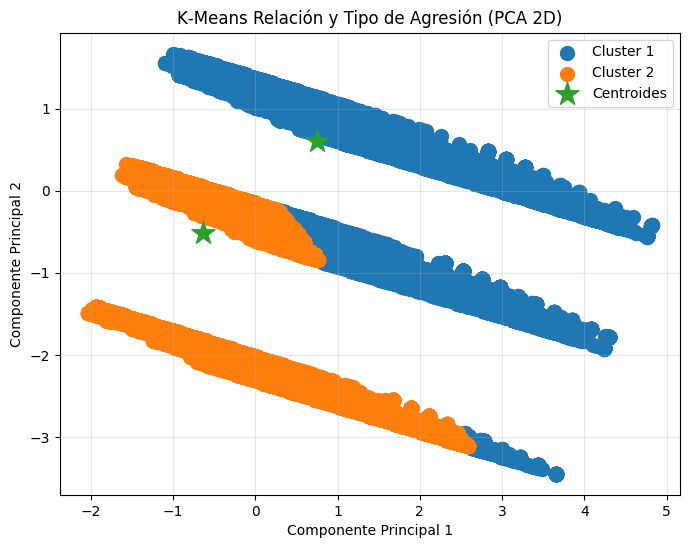

In [17]:
# -------------- GRUPO 5: Relaci√≥n y Tipo de Agresi√≥n (PCA + KMeans) --------------

# Aplicar PCA a df_relacion_agresion_scaled (3 variables) para reducir a 2 dimensiones
pca_rel_agresion = PCA(n_components=2, random_state=42)
X_pca_rel_agresion = pca_rel_agresion.fit_transform(df_relacion_agresion_scaled)

# Mostrar varianza explicada por las 2 componentes principales
print("Varianza explicada por PC1 y PC2 (Relaci√≥n y tipo de agresi√≥n):", pca_rel_agresion.explained_variance_ratio_)

# Mostrar tabla de loadings (contribuci√≥n de cada variable al PCA)
loadings_rel_agresion = pd.DataFrame(
    pca_rel_agresion.components_.T,
    columns=["PC1", "PC2"],
    index=["VIC_REL_AGR", "HEC_TIPAGRE", "VIC_EDAD"]
)
print("\nLoadings (contribuci√≥n de cada variable al PCA):\n", loadings_rel_agresion)

# Clustering K‚ÄëMeans con 2 clusters (seg√∫n an√°lisis) sobre las componentes principales
km_rel_agresion = KMeans(n_clusters=2, random_state=42).fit(X_pca_rel_agresion)
labels_rel_agresion = km_rel_agresion.labels_
centroids_rel_agresion = km_rel_agresion.cluster_centers_

# Graficar los clusters en 2D
plt.figure(figsize=(8,6))
for cluster in range(2):
    mask = (labels_rel_agresion == cluster)
    plt.scatter(X_pca_rel_agresion[mask, 0],
                X_pca_rel_agresion[mask, 1],
                s=100,
                label=f'Cluster {cluster+1}')
plt.scatter(centroids_rel_agresion[:, 0],
            centroids_rel_agresion[:, 1],
            marker='*',
            s=300,
            label='Centroides')
plt.title("K‚ÄëMeans Relaci√≥n y Tipo de Agresi√≥n (PCA 2D)")
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

El gr√°fico revela una separaci√≥n clara entre dos clusters principales, lo cual indica que los tipos de relaci√≥n v√≠ctima-agresor combinados con el tipo de agresi√≥n tienden a agruparse en dos patrones distintos de comportamiento:

- **Cluster 1 (azul):** Se ubica en la parte superior del gr√°fico PCA, sugiriendo un grupo con relaciones y agresiones posiblemente m√°s directas o frecuentes, como parejas o familiares cercanos.

- **Cluster 2 (naranja):** Ocupa una regi√≥n inferior, lo que puede representar situaciones menos convencionales o con din√°micas distintas de violencia, como agresiones por exparejas, conocidos o entornos m√°s distantes.

La reducci√≥n a componentes principales conserva bien la estructura, y los centroides verdes confirman que ambos grupos est√°n bien definidos y tienen una separaci√≥n significativa. Esta diferenciaci√≥n puede ser clave para dise√±ar protocolos diferenciados de atenci√≥n y prevenci√≥n seg√∫n el tipo de v√≠nculo y agresi√≥n reportada.

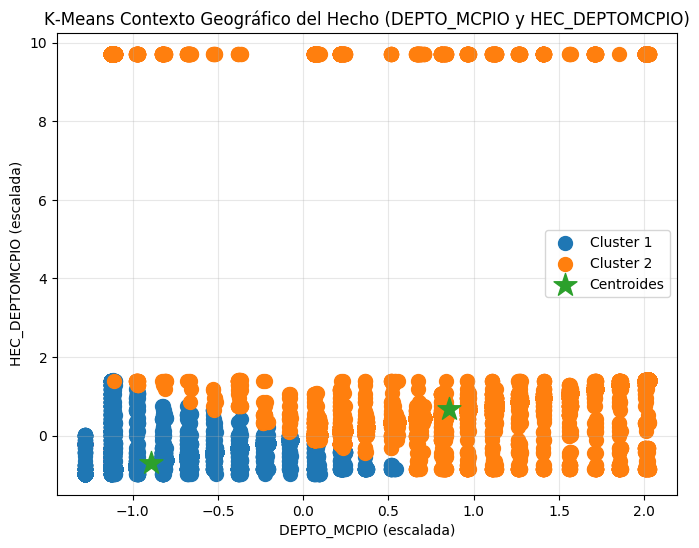

In [18]:
# -------------- GRUPO 6: Contexto Geogr√°fico del Hecho --------------

# Seleccionar s√≥lo las dos columnas de inter√©s
X_contexto_geografico = df_contexto_geografico_scaled

# Ajustar K‚ÄëMeans
km_contexto_geografico = KMeans(n_clusters=2, random_state=42).fit(X_contexto_geografico)
labels_contexto_geografico = km_contexto_geografico.labels_
centroids_contexto_geografico = km_contexto_geografico.cluster_centers_

# Graficar resultados en 2D
plt.figure(figsize=(8,6))
for cluster in range(2):
    mask = (labels_contexto_geografico == cluster)
    plt.scatter(X_contexto_geografico[mask, 0],
                X_contexto_geografico[mask, 1],
                s=100,
                label=f'Cluster {cluster+1}')

plt.scatter(centroids_contexto_geografico[:, 0],
            centroids_contexto_geografico[:, 1],
            marker='*',
            s=300,
            label='Centroides')

plt.title("K‚ÄëMeans Contexto Geogr√°fico del Hecho (DEPTO_MCPIO y HEC_DEPTOMCPIO)")
plt.xlabel("DEPTO_MCPIO (escalada)")
plt.ylabel("HEC_DEPTOMCPIO (escalada)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

### An√°lisis del Clustering: Contexto Geogr√°fico del Hecho

El gr√°fico presenta dos clusters principales que reflejan diferencias en la ubicaci√≥n geogr√°fica donde ocurre el hecho versus el lugar donde se denuncia:

- **Cluster 1 (azul):** Se concentra en valores bajos de ambas variables, lo que puede sugerir hechos y denuncias localizadas en zonas m√°s cercanas o menos dispersas geogr√°ficamente (probablemente √°reas rurales o departamentos con menor movilidad).

- **Cluster 2 (naranja):** Se extiende hacia valores m√°s altos, en especial en `HEC_DEPTOMCPIO`, lo que indica una mayor dispersi√≥n en los lugares donde ocurren los hechos y se denuncian, posiblemente reflejando desplazamiento entre el lugar del hecho y la denuncia o mayor dinamismo urbano.

Los centroides (estrellas verdes) muestran que la segmentaci√≥n espacial tiene sentido y puede ser √∫til para analizar flujos territoriales de denuncia, lo cual podr√≠a guiar decisiones sobre distribuci√≥n de recursos institucionales (como comisar√≠as o fiscal√≠as m√≥viles).

## Clustering Jer√°rquico

Using a random subset of 1000 samples from 498234 observations for hierarchical clustering.


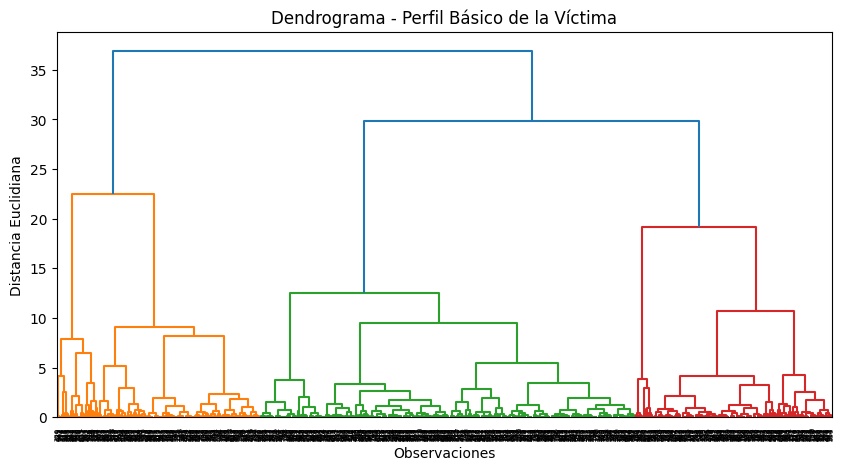

Using a random subset of 1000 samples from 498234 observations for hierarchical clustering.


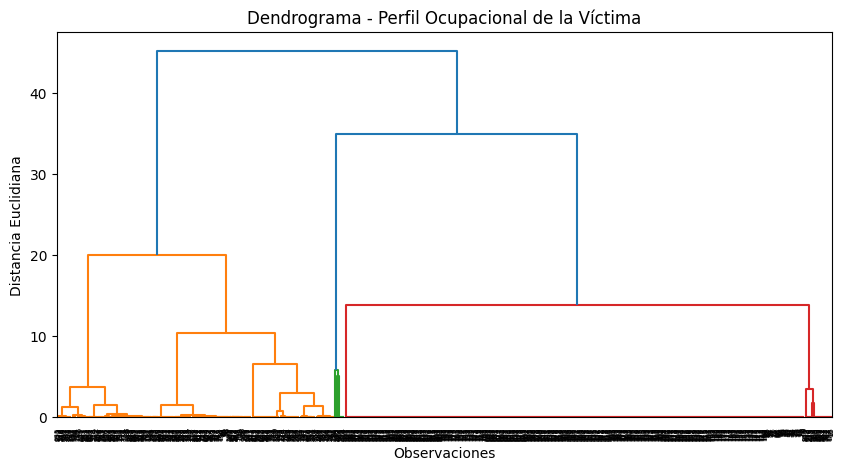

Using a random subset of 1000 samples from 498234 observations for hierarchical clustering.


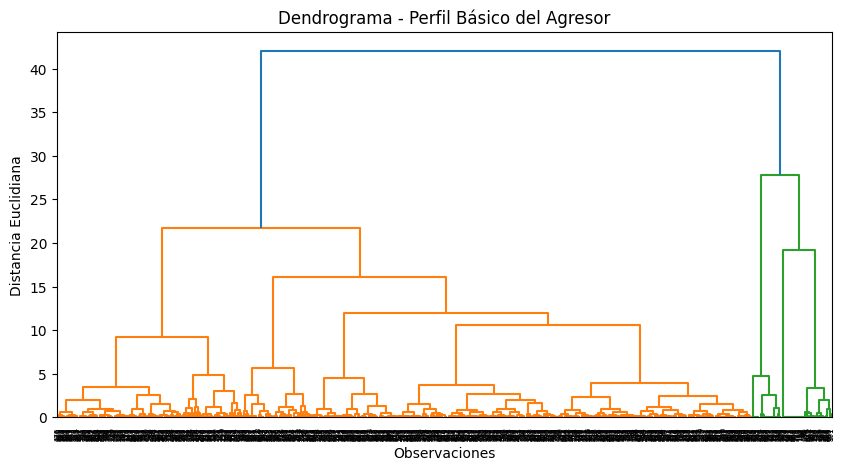

Using a random subset of 1000 samples from 498234 observations for hierarchical clustering.


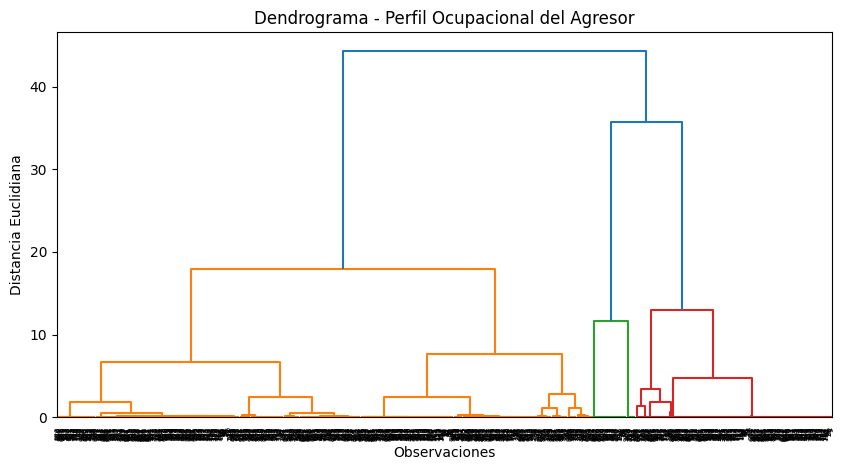

Using a random subset of 1000 samples from 498234 observations for hierarchical clustering.


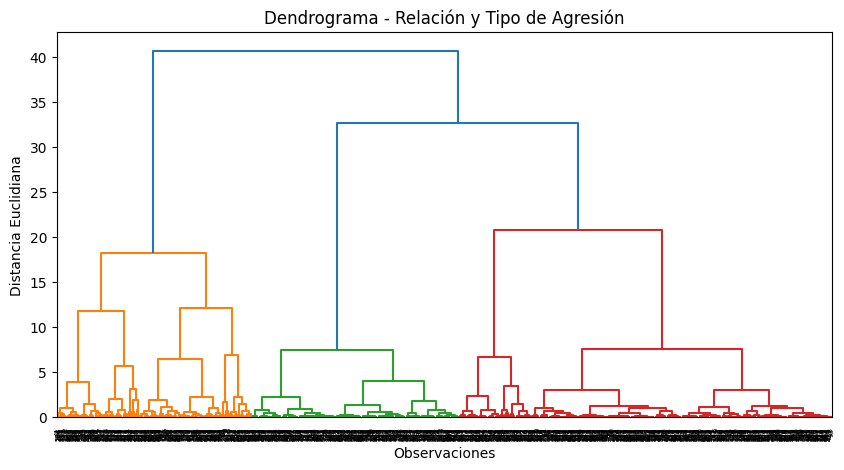

Using a random subset of 1000 samples from 498234 observations for hierarchical clustering.


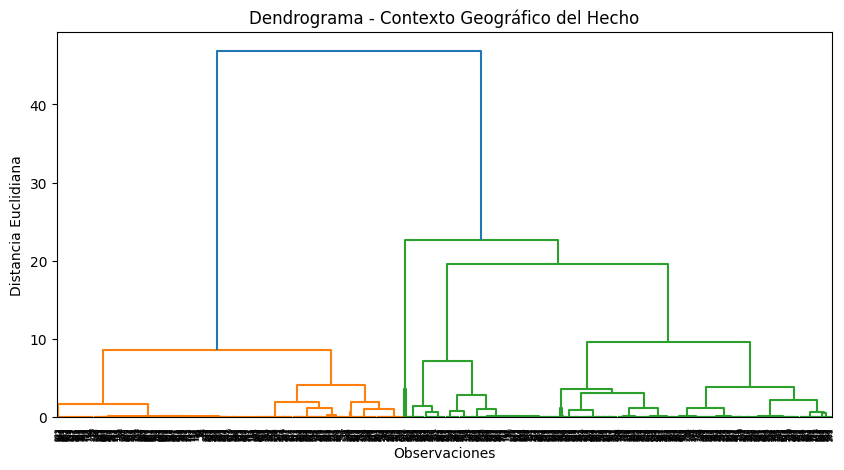

In [19]:
sys.setrecursionlimit(15000)

def hierarchical_clustering(X, group_label, sample_size=1000):
    # Sample the data if too many observations to reduce memory usage.
    if len(X) > sample_size:
        print(f"Using a random subset of {sample_size} samples from {len(X)} observations for hierarchical clustering.")
        np.random.seed(42)
        indices = np.random.choice(len(X), size=sample_size, replace=False)
        X_used = X[indices]
    else:
        X_used = X

    plt.figure(figsize=(10, 5))
    sch.dendrogram(sch.linkage(X_used, method='ward'))
    plt.title(f"Dendrograma - {group_label}")
    plt.xlabel("Observaciones")
    plt.ylabel("Distancia Euclidiana")
    plt.show()

# 1Ô∏è‚É£ Preparar matrices (PCA donde corresponde)
pca = PCA(n_components=2, random_state=42)

X_perfil_victima = df_perfil_victima_scaled
X_ocupacion_victima = df_ocupacion_victima_scaled
X_perfil_agresor = df_perfil_agresor_scaled
X_ocupacion_agresor = df_ocupacion_agresor_scaled
X_pca_rel_agresion = pca.fit_transform(df_relacion_agresion_scaled)
X_contexto_geografico = df_contexto_geografico_scaled

# 2Ô∏è‚É£ Ejecutar dendrogramas
hierarchical_clustering(X_perfil_victima, "Perfil B√°sico de la V√≠ctima")
hierarchical_clustering(X_ocupacion_victima, "Perfil Ocupacional de la V√≠ctima")
hierarchical_clustering(X_perfil_agresor, "Perfil B√°sico del Agresor")
hierarchical_clustering(X_ocupacion_agresor, "Perfil Ocupacional del Agresor")
hierarchical_clustering(X_pca_rel_agresion, "Relaci√≥n y Tipo de Agresi√≥n")
hierarchical_clustering(X_contexto_geografico, "Contexto Geogr√°fico del Hecho")

En los dendrogramas presentados para cada grupo de variables, se observa una clara formaci√≥n jer√°rquica de cl√∫steres, lo cual sugiere que los datos tienen estructura y permiten una separaci√≥n significativa en subgrupos. El dendrograma del Perfil B√°sico de la V√≠ctima muestra una divisi√≥n clara en aproximadamente tres grandes grupos, validando lo sugerido por el an√°lisis con K-Means. De manera similar, el dendrograma de Perfil Ocupacional de la V√≠ctima refleja una agrupaci√≥n m√°s abrupta, con un grupo muy dominante y otros m√°s dispersos, lo que podr√≠a se√±alar patrones laborales muy comunes entre las v√≠ctimas.

En el caso del Perfil B√°sico del Agresor, se distinguen al menos dos cl√∫steres bien definidos, en l√≠nea con lo identificado previamente, lo que indica homogeneidad en ciertos perfiles de agresores. El Perfil Ocupacional del Agresor tambi√©n refleja heterogeneidad, aunque con una estructura m√°s ramificada, lo cual puede deberse a la diversidad de ocupaciones y actividades entre agresores.

El dendrograma de Relaci√≥n y Tipo de Agresi√≥n muestra una estructura m√°s balanceada, con al menos tres divisiones grandes y progresivas, lo cual sugiere que los tipos de agresi√≥n y la relaci√≥n v√≠ctima-agresor tienen patrones bien diferenciables. Por √∫ltimo, el dendrograma del Contexto Geogr√°fico del Hecho revela una separaci√≥n menos abrupta pero a√∫n clara, posiblemente influenciada por la distribuci√≥n de los departamentos y municipios involucrados en los casos.

En conjunto, estos dendrogramas refuerzan la validez de los cl√∫steres obtenidos con K-Means y respaldan la segmentaci√≥n propuesta en el an√°lisis, destacando que la agrupaci√≥n jer√°rquica aporta una visi√≥n complementaria √∫til para entender la estructura latente en los datos.